# Cross Movements Results Figure
Shows the information about PAA analysis and ROI contributions within participants

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec
from nilearn import plotting as ni_plt

import json, pickle
from tqdm import tqdm
import sys, os, pdb

from src.data_utils import ECoG_Data
import src.manifold_u as mu
import importlib
importlib.reload(mu)
import fig_utils as figu
importlib.reload(figu)

plt.style.use(['science', 'retro'])
sns.set_style("ticks")
plt.rcParams.update({"font.size": 10})

In [2]:
movement_colors, day_colors, participant_colors, exp_class_colors, exp_participant_colors, freq_colors = mu.get_all_colors()

In [3]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_nat_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])

Param file for running PCA pipeline on naturalistic data


In [4]:
freq_bands = exp_params["freq_bands"]
class_dict = exp_params["class_dict"]
class_dict = {int(cur_key) - 1: val for cur_key, val in class_dict.items() if val != 'rest'}
class_color = exp_params["class_color"]
class_color = {int(cur_key): val for cur_key, val in class_color.items()}

proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]

percent_threshold = 0.8
pats_ids_in = exp_params["pats_ids_in"]

cur_freq = 'Beta'
cur_freq_ind = 2
freq_red_dim = 10

In [5]:
data_slice_fig_path = '/home/zsteineh/research_projects/neural_manifolds/scripts/final_scripts/journal_figures/Q1_data_slice.png'
data_slice = plt.imread(data_slice_fig_path)

In [6]:
cross_move_pas = pickle.load(open(proj_mat_sp + 'freq_cross_move_pas.pkl', 'rb'))
print(cross_move_pas.keys())

null_data_pa = np.load(exp_params['null_data_lp'] + 'TME_null_pas.npy')
print(null_data_pa.shape)

cross_move_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_move_nd_df.csv')
print(cross_move_nd_df)

dict_keys(['LFO', 'Alpha', 'Beta', 'Low Gamma', 'Gamma', 'High Gamma'])


(6, 12, 1000, 1, 1, 10, 15)
        Unnamed: 0   Frequency Participant   Day Movement Comparison  \
0                0         LFO         P01     3        left vs down   
1                1         LFO         P01     3       left vs right   
2                2         LFO         P01     3          left vs up   
3                3         LFO         P01     3       down vs right   
4                4         LFO         P01     3          down vs up   
...            ...         ...         ...   ...                 ...   
434155       72355  High Gamma        Null  Null       left vs right   
434156       72356  High Gamma        Null  Null          left vs up   
434157       72357  High Gamma        Null  Null       down vs right   
434158       72358  High Gamma        Null  Null          down vs up   
434159       72359  High Gamma        Null  Null         right vs up   

        Neural Dissimilarity  
0                   0.108478  
1                        NaN  
2             

In [7]:
exp_params['test_day'] = 'last'
manifold_ECoG_data = ECoG_Data(exp_params, proj_mat_sp)
roi_centroids = manifold_ECoG_data.roi_centroids

Determining ROIs


  0%|          | 0/12 [00:00<?, ?it/s]

ROIs found
Number of ROIs:  311
loading steve data
Pulling out last for test day


  8%|▊         | 1/12 [00:08<01:31,  8.32s/it]

loading steve data
Pulling out last for test day


 17%|█▋        | 2/12 [00:11<01:06,  6.68s/it]

loading steve data
Pulling out last for test day


 25%|██▌       | 3/12 [00:17<01:00,  6.70s/it]

loading steve data
Pulling out last for test day


 33%|███▎      | 4/12 [00:21<00:46,  5.78s/it]

loading steve data
Pulling out last for test day


 42%|████▏     | 5/12 [00:25<00:35,  5.09s/it]

loading steve data
Pulling out last for test day


 50%|█████     | 6/12 [00:35<00:39,  6.65s/it]

loading steve data
Pulling out last for test day


 58%|█████▊    | 7/12 [00:42<00:34,  6.80s/it]

loading steve data
Pulling out last for test day


 67%|██████▋   | 8/12 [00:54<00:33,  8.28s/it]

loading steve data
Pulling out last for test day


 75%|███████▌  | 9/12 [00:57<00:20,  6.87s/it]

loading steve data
Pulling out last for test day


 83%|████████▎ | 10/12 [01:03<00:13,  6.65s/it]

loading steve data
Pulling out last for test day


 92%|█████████▏| 11/12 [01:11<00:06,  6.88s/it]

loading steve data
Pulling out last for test day


100%|██████████| 12/12 [01:19<00:00,  6.63s/it]


Data loaded!


In [8]:
all_sbjs_pca = []
for f, freq in enumerate(freq_bands):
    cur_pca = np.load(proj_mat_sp + freq + '_pca_objects.npy', allow_pickle=True)
    all_sbjs_pca.append(cur_pca)
all_sbjs_pca = np.array(all_sbjs_pca)
print(all_sbjs_pca.shape)

# get VAF - variance per movement
pca_manifolds_VAF = mu.extract_explained_var(
    class_dict, freq_bands, pats_ids_in, all_sbjs_pca
)
# pca_manifolds_VAF shape of (num_freqs, num_sbjs, num_days, num_mvmts, num_components)
# extract just LFO
LFO_pca_manifolds_VAF = pca_manifolds_VAF[0,...]
print(LFO_pca_manifolds_VAF.shape)

# get average across mvmts and std
Q1_avg_mvmt_subj_components = np.nanmean(LFO_pca_manifolds_VAF, axis=(0, 1))
Q1_std_mvmt_subj_components = np.nanstd(LFO_pca_manifolds_VAF, axis=(0, 1))
# remove the rest data
Q1_avg_mvmt_subj_components = Q1_avg_mvmt_subj_components[1:]
Q1_std_mvmt_subj_components = Q1_std_mvmt_subj_components[1:]

(6, 12, 5, 5)
(12, 5, 5, 311)


In [9]:
# pull the current freq data out
cur_freq_only = cross_move_nd_df.loc[
    (cross_move_nd_df["Frequency"] == cur_freq)
    | (cross_move_nd_df["Frequency"] == "Null")
]
print(cur_freq_only)

q1_sigf_val = mu.calc_sumed_significance(cross_move_nd_df)
print(q1_sigf_val)

        Unnamed: 0 Frequency Participant   Day Movement Comparison  \
144720           0      Beta         P01     3        left vs down   
144721           1      Beta         P01     3       left vs right   
144722           2      Beta         P01     3          left vs up   
144723           3      Beta         P01     3       down vs right   
144724           4      Beta         P01     3          down vs up   
...            ...       ...         ...   ...                 ...   
217075       72355      Beta        Null  Null       left vs right   
217076       72356      Beta        Null  Null          left vs up   
217077       72357      Beta        Null  Null       down vs right   
217078       72358      Beta        Null  Null          down vs up   
217079       72359      Beta        Null  Null         right vs up   

        Neural Dissimilarity  
144720              0.117511  
144721                   NaN  
144722                   NaN  
144723                   NaN  
1447

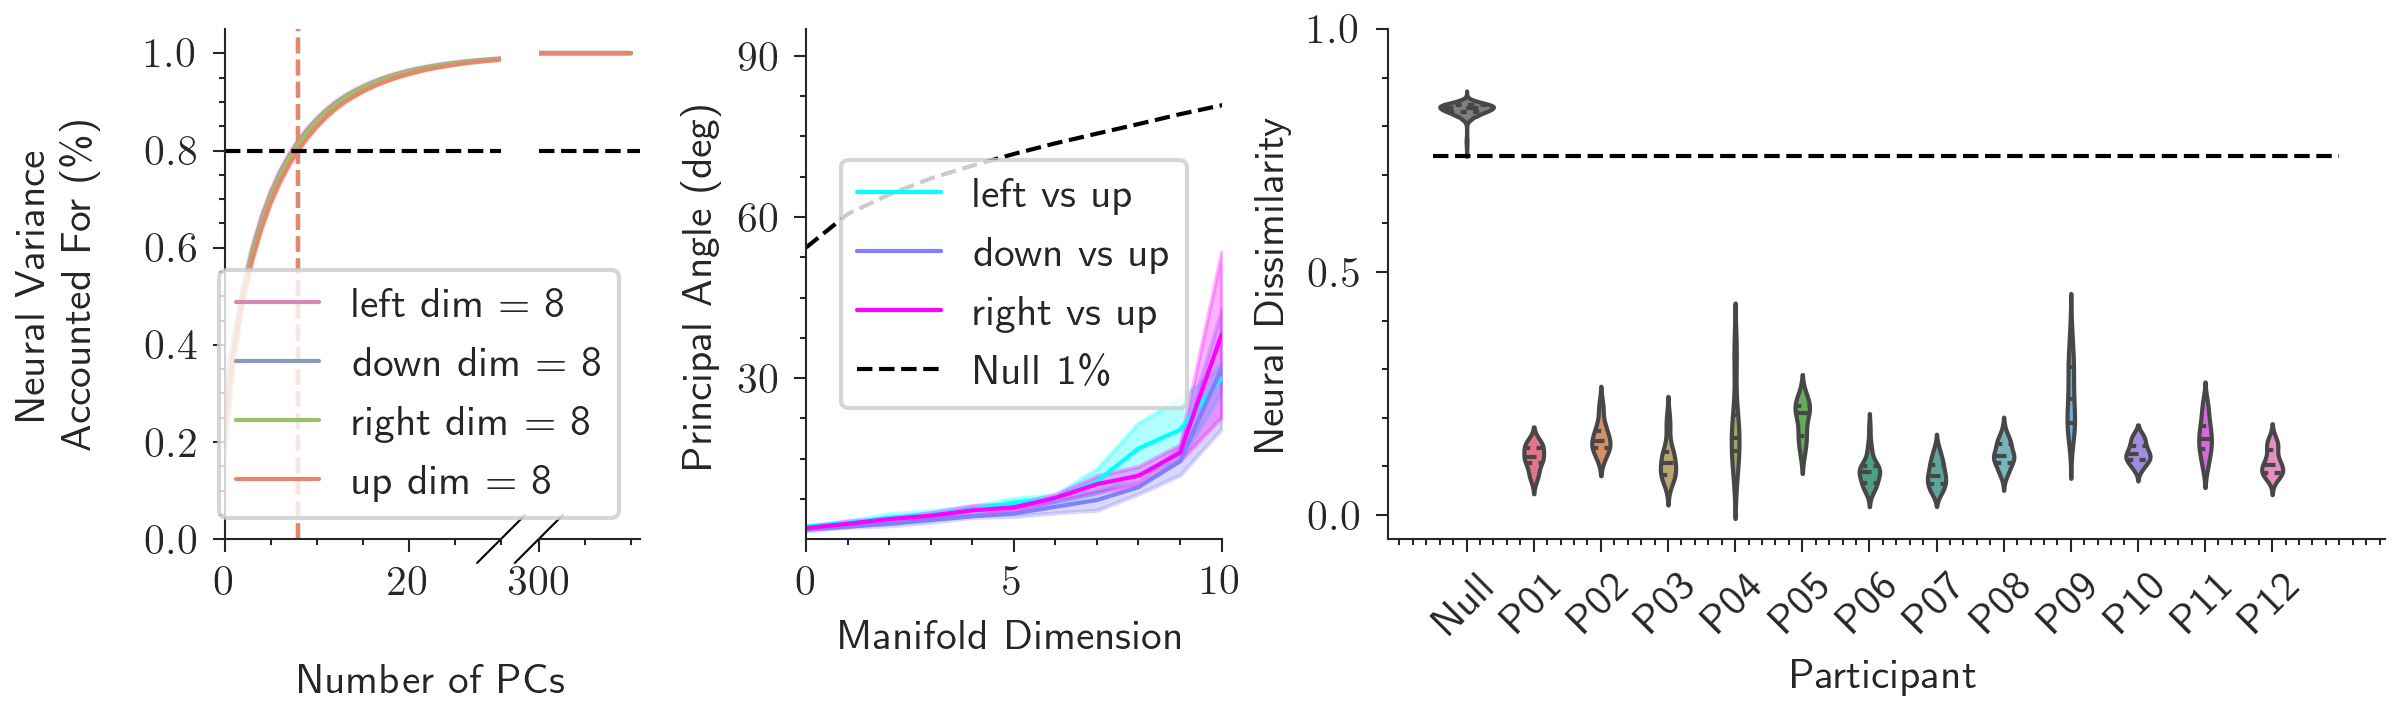

In [10]:
fig, axes = plt.subplots(figsize=(7.5, 2.0), dpi=300)
plt.axis('off')
sns.despine()
plt.tight_layout()

axes = GridSpec(1,4, figure=fig)
axes.update(wspace=0.4, hspace=0.3)

# VAF figure first
ax0 = axes[0,0]
figu.subplot_VAF(Q1_avg_mvmt_subj_components, 
            Q1_std_mvmt_subj_components, 
            list(class_dict.values()), 
            "Naturalistic Movements", 
            movement_colors, 
            ax0)

# PA figure
ax1 = plt.subplot(axes[0,1:2])
comps_to_plot = [2, 4, 5]
null_pa = np.array(null_data_pa[0][0])
signf_null_pas = np.squeeze(np.percentile(null_pa, 1, axis=0).mean(axis=2))

figu.plot_PAs(ax1, 
            class_dict, 
            comps_to_plot, 
            np.transpose(np.expand_dims(cross_move_pas['Beta'], axis=0), (2, 0, 1, 3, 4)), 
            null_data_pa, 
            null_sig_pas = signf_null_pas,
            red_dim = freq_red_dim, 
            fill_between = True)

# neural dissimilarity figure
order = ["Null"]
order.extend(pats_ids_in)
ax2 = plt.subplot(axes[0,2:])
# ax1 = axes[1]
figu.plot_neural_dissimilarity(ax2, cur_freq_only, q1_sigf_val, order, participant_colors)

plt.savefig("/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/cross_move_results.svg", format="svg")
plt.show()

### Get the reporting numbers

In [11]:
avg_pas = np.round(np.nanmean(cross_move_pas['Beta'], axis=(0, 1, 2)), 3)
std_pas = np.round(np.nanstd(cross_move_pas['Beta'], axis=(0, 1, 2)), 3)
print("First PA Average: ", avg_pas[0])
print("First PA STD: ", std_pas[0])
print("Last PA Average: ", avg_pas[-1])
print("Last PA STD: ", std_pas[-1])

First PA Average:  2.691
First PA STD:  1.676
Last PA Average:  48.844
Last PA STD:  20.394


In [12]:
avg_pat_nd = np.round(cur_freq_only[cur_freq_only["Participant"] != "Null"]['Neural Dissimilarity'].mean(), 3)
std_pat_nd = np.round(cur_freq_only[cur_freq_only["Participant"] != "Null"]['Neural Dissimilarity'].std(), 3)
print("Average Cross Movement Neural Dissimilarity: ", avg_pat_nd)
print("STD Cross Movement Neural Dissimilarity: ", std_pat_nd)

Average Cross Movement Neural Dissimilarity:  0.142
STD Cross Movement Neural Dissimilarity:  0.063


In [13]:
print("Null 1% Significance:", np.round(q1_sigf_val, 3))

Null 1% Significance: 0.739


### Get the ROI Contrib Plots

#### P01 Contribs

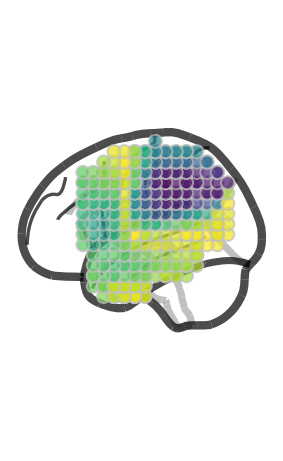

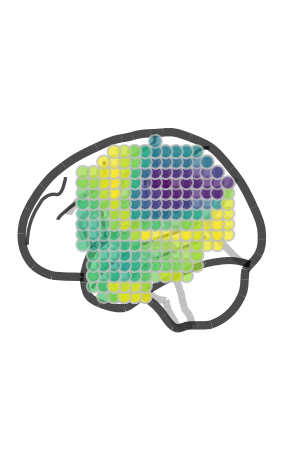

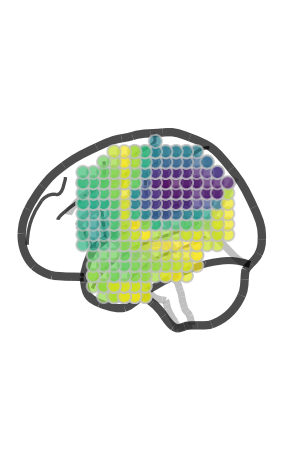

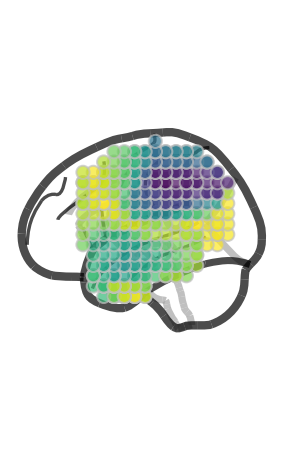

In [14]:
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.rcParams.update({"font.size": 10})
plt.tight_layout()

# left PCs
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,0,1,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# down PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,0,1,2]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# right PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,0,1,3]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# up PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,0,1,4]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

#### P09 Contribs

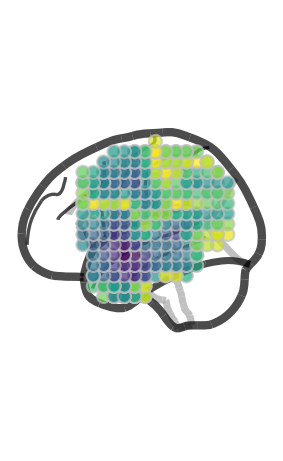

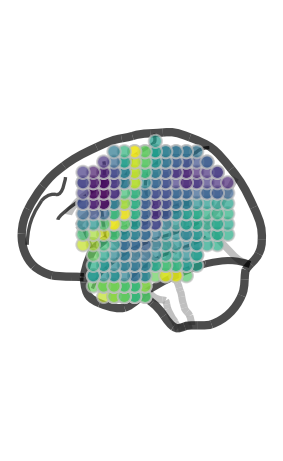

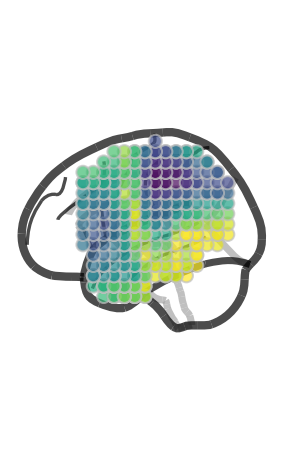

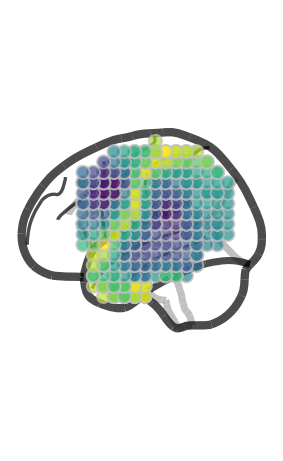

In [15]:
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.rcParams.update({"font.size": 10})
plt.tight_layout()

# left PCs
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,8,0,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[-1]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# down PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,8,0,2]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# right PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,8,0,3]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()

# up PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,8,0,4]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
# ax1.set_title("C) Example First PC\nContributions for P01\non Left Reaches")
plt.show()